## Step 1: Value import


In [ ]:
from utils.file_handling import *
from utils.misc import *
from utils.matplot_handlers import *
from utils.visualizers import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Entropy Parameters
csv_file_name = 'cartpole'
episodes = -1
action_value_name = 'action_value_action_0'
state_value_name = 'state_values'

pre_data = pd.read_csv(get_absolute_path('data', directory_file_hint=csv_file_name, ignore_files=False), index_col=None)

In [ ]:
selected_episodes = pre_data['episode'].unique()[episodes]  # Either do [some index] or [:]
selected_episodes = [selected_episodes] if np.isscalar(selected_episodes) else selected_episodes
data_df = pre_data[[action_value_name, state_value_name, 'episode']]
data_df = data_df[data_df['episode'].isin(selected_episodes)]
data_df_episodes = []
for episode in selected_episodes:
    data_df_episodes.append(data_df[data_df['episode'] == episode].copy())

In [3]:
data_df[:20]

,action_value_action_0,state_values,episode
839,0.0,"[0.029677305431470822, -0.16573410934739966, -...",151
840,0.0,"[0.026362623244522827, -0.36030588468154895, -...",151
841,1.0,"[0.01915650555089185, -0.1647670263324457, -0....",151
842,1.0,"[0.015861165024242938, 0.03061646276223004, -0...",151
843,1.0,"[0.01647349427948754, 0.2259175917022173, -0.0...",151
844,0.0,"[0.020991846113531887, 0.030977149520858893, -...",151
845,0.0,"[0.021611389103949066, -0.16387577346067483, -...",151
846,0.0,"[0.01833387363473557, -0.35872898044168333, -0...",151
847,0.0,"[0.011159294025901902, -0.5536684433439286, -0...",151
848,1.0,"[8.592515902332981e-05, -0.35852674908544635, ...",151


## Step 2: Value Convertion / Cleaning
We just need to make sure that the data is in a numpy array format for easier manipulation

In [4]:
data_episodes = df_to_numpy(data_df_episodes)
index = 0

plots = [PlotObject(plot_type=PlotObject.TYPE_REGULAR, 
                    values=data_episodes[index][name], 
                    name=name,
                    meta_type=PlotObject.META_ACTION) for name in data_episodes[index] if name.__contains__('action')]
temp_plot = [PlotObject(plot_type=PlotObject.TYPE_REGULAR, 
              values=data_episodes[index][name], 
              name=name,
              meta_type=PlotObject.META_STATE) for name in data_episodes[index] if name.__contains__('state')]
plots += [PlotObject(plot_type=PlotObject.TYPE_REGULAR, 
                    values=obj.values[:, d], name=obj.name + f'_{d}', 
                    meta_type=PlotObject.META_STATE) for obj in temp_plot for d in range(obj.values.shape[1])]

In [5]:
plots[2].values.shape

(200,)

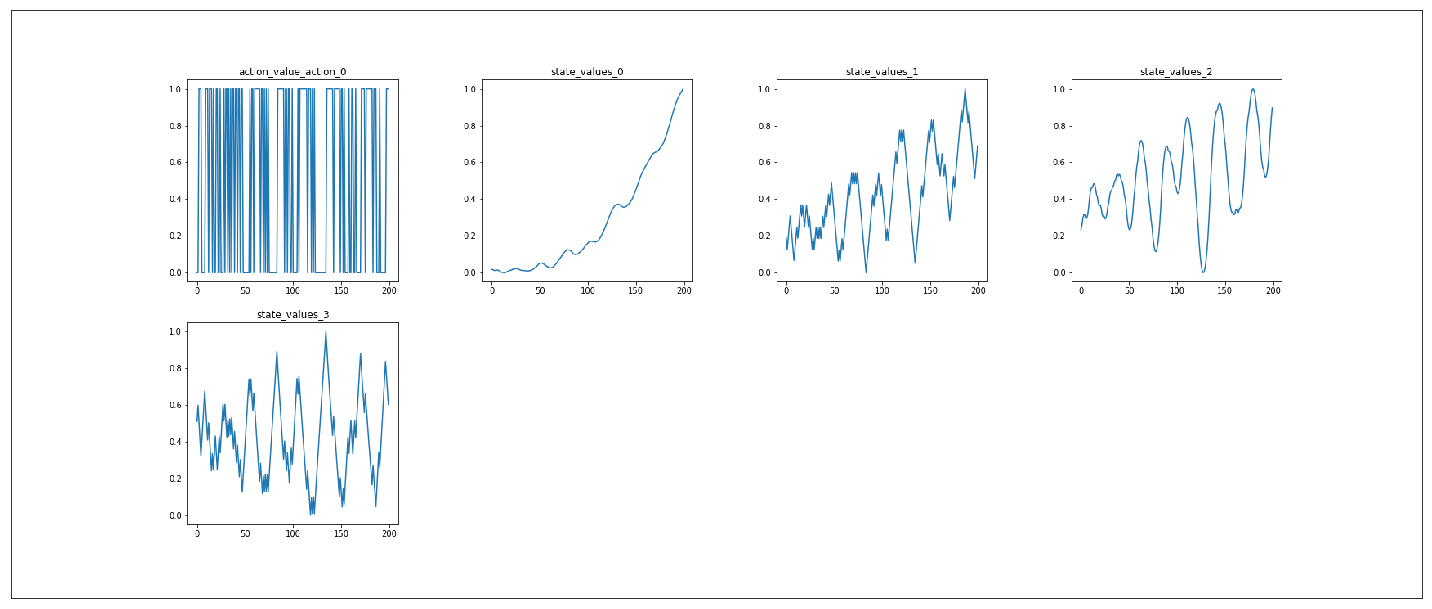

In [6]:
from utils.matplot_handlers import *
plt.figure(figsize=(20, 20))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.imshow(MatplotHandler.get_figure_image(plots))

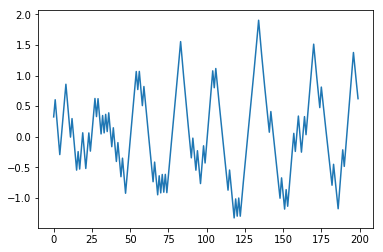

In [7]:
index_of_interest = -1
plt.plot(plots[index_of_interest].values)

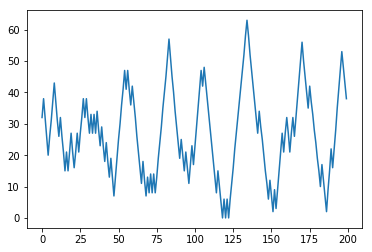

In [8]:
plt.plot(bin_numpy(plots[index_of_interest].values))

## Step 2: Binning Values
We have tested entropy functions, divergence functions, and distance metrics for action extraction.

A couple things to note before testing our functions. In an ideal world, our state and action inputs would be inherently discrete. However, this quicky becomes not possible, so we convert them to discrete. This is the actual start of our method for extracting composite actions. By default, ```bin_numpy``` defaults to binning values into 64 bins. 

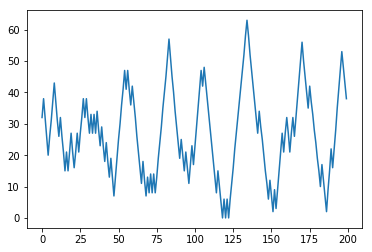

In [44]:
from utils.entropy_functions import *
w = 10  # Window size
X = bin_numpy(plots[index_of_interest].values)
plt.plot(X)

## Step 3.a: Entropy Series
In order to extract the entropy from the sequence, we need the sequence to be in the form of a probability distribution. We have tested multiple distribution extracting methods:

- Frequent approach:
Given a set $X$, a real numeric sequence such as our state sequence above, we simply calculate:

${P(x_i)} = \lim\limits_{n_t \to \infty} \frac{x_i}{n_t}$

Where $n_t$ is the total number of elements in the set. **However the main draw back with extracting probabilities from using this is that the probability of a value is not simply the mere existance of it and number of occurances of it, but the known previous states**.

Since we are concerned with the the entropy of the current state relative to the previous states, need to be to attack this problem from a different direction. Luckly there exists many entropy functions / metrics for this time series entropy analysis.

One of the common parts of our algorithm is that we will be sliding a window size.

So given $X$ and an entropy/divergence/metric function $f(x)$ and given a windows size $w$:

$E = \{f(x_{i + w})  |  x_i \in X\}$

Window size $w$ is the first parameter in our algorithm.

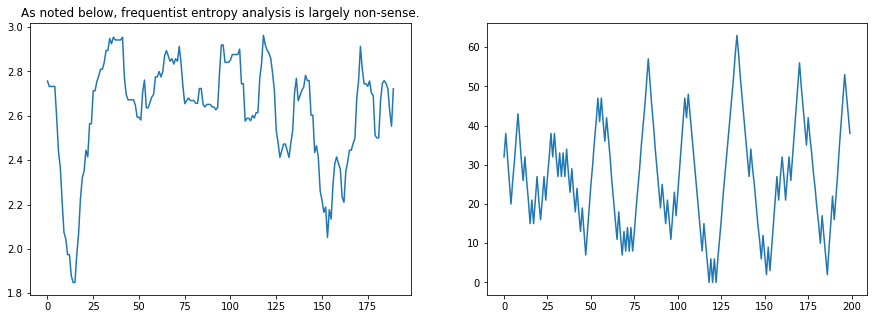

In [45]:
entropy_func_comparison([entropy_regular(x_i, get_frequentest_probability(X)) for x_i in windowed_numpy(get_frequentest_probability(X), w)], X, 
                        title='As noted below, frequentist entropy analysis is largely non-sense.')

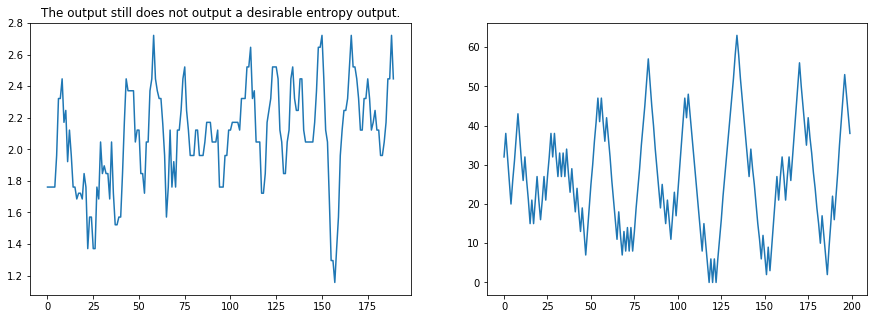

In [46]:
entropy_func_comparison([entropy_shannon(x_i) for x_i in windowed_numpy(get_frequentest_probability(X), w)], X, 
                        title='The output still does not output a desirable entropy output.')

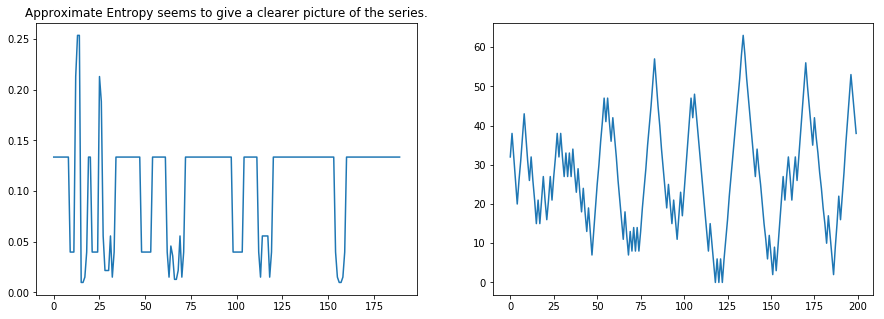

In [47]:
X = bin_numpy(plots[index_of_interest].values)
entropy_func_comparison([entropy_approximate(x_i, 3, 1) for x_i in windowed_numpy(X, w)], X, 
                        title='Approximate Entropy seems to give a clearer picture of the series.')

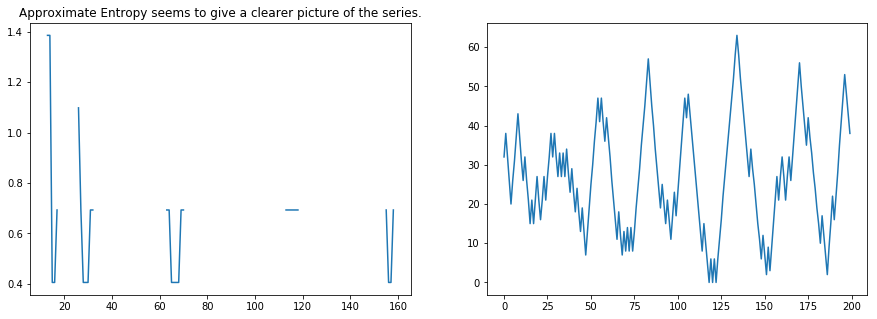

In [48]:
entropy_func_comparison([entropy_sample(x_i, 3, 2) for x_i in windowed_numpy(X, w)], X, 
                        title='Approximate Entropy seems to give a clearer picture of the series.')

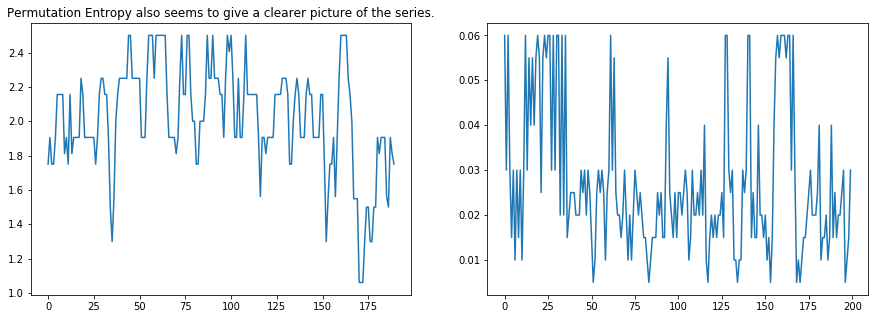

In [49]:
X = get_frequentest_probability(bin_numpy(plots[index_of_interest].values))
entropy_func_comparison([entropy_permutation(x_i) for x_i in windowed_numpy(X, w)], X, 
                        title='Permutation Entropy also seems to give a clearer picture of the series.')

## Step 3.b: Divergence / Distance Metrics
The largest issue with all of the entropy graphs above is that they are simply still measuring the entropy of sequence of data, as opposed to entropy of patterns. If an agent has an actions of `[0, 1, 0, 1, 0, 1]`, each of these entropy functions will still say there is entropy, however we want them to say that there is **no entropy** since the pattern repeats and thus nothing new is present.

A key issue for doing divergence and distance metrics is the question of what 2 distributions are we going to use for logging the entropy at a specific time step?

Well, given $w$ our window size, $X$ our series, and $d(p, q)$ our distance function, we log the resulting entropy / distance / divergence via:

$E = \{min(D(x_{i + w}, x_{w_{i + 1\to w}})) | x_i \in X\}$

What we are doing as at any given time step, look at the nearest neighbors of which yield a pattern that has the lowest possible entropy.


In [50]:
X = bin_numpy(plots[index_of_interest].values)
X_w = windowed_numpy(get_frequentest_probability(X))

$ D_{KL}(P \| Q) = \displaystyle\sum_{x \in X} P(x) \log(\frac{Q(x)}{P(x)})$

As seen at https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

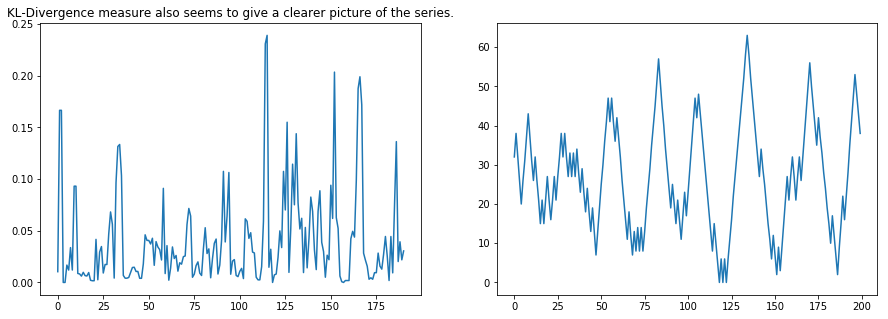

In [51]:
from utils.divergence_distance_functions import *
entropy_func_comparison([min([kl_divergence(X_w[i], q) for q in X_w[i + 1:i + w]]) for i in range(len(X_w) - w // 2)], X, 
                        title='KL-Divergence measure also seems to give a clearer picture of the series.')

${{\rm {JSD}}}(P\parallel Q)={\frac  {1}{2}}D(P\parallel M)+{\frac  {1}{2}}D(Q\parallel M)$

where ${\displaystyle M={\frac {1}{2}}(P+Q)} M={\frac  {1}{2}}(P+Q)$

As seen at https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

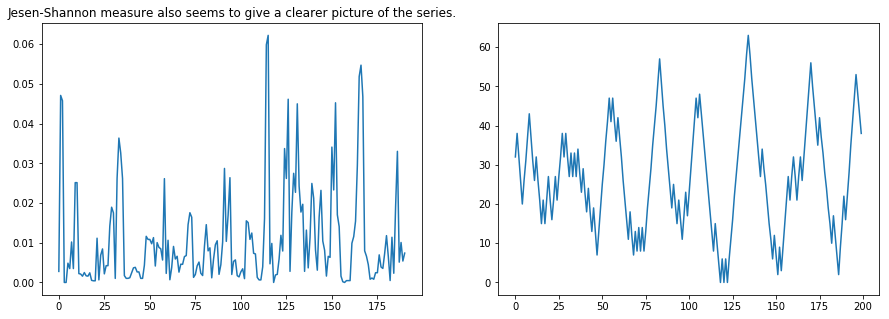

In [52]:
entropy_func_comparison([min([jensen_shannon_divergence(X_w[i], q) for q in X_w[i + 1:i + w]]) for i in range(len(X_w) - w // 2)], X, 
                        title='Jesen-Shannon measure also seems to give a clearer picture of the series.')

$\displaystyle \delta(\mathcal {P_r}, \mathcal {P_g}) =\sup _{\mathcal {A \in \sum}}|\mathcal{P_r(A)} - \mathcal{P_g(A)}|$

Sum in https://arxiv.org/pdf/1701.07875.pdf


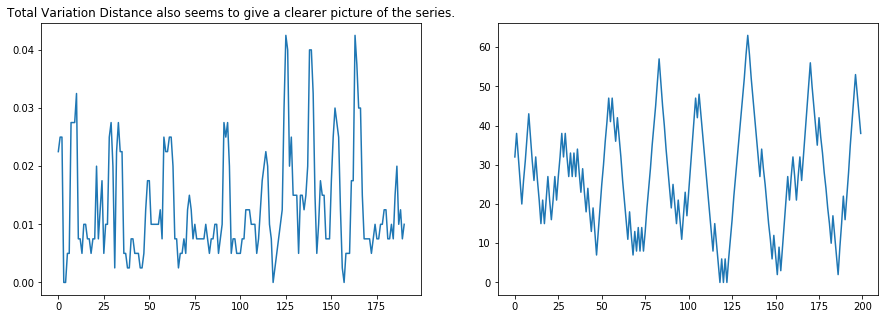

In [53]:
entropy_func_comparison([min([total_variation_distance(X_w[i], q) for q in X_w[i + 1:i + w]]) for i in range(len(X_w) - w // 2)], X, 
                        title='Total Variation Distance also seems to give a clearer picture of the series.')

$\displaystyle \mathcal{l_1}(u, v)=\inf_{\mathcal {\pi \in \Gamma(u, v)}}\int_{\mathcal{R \times R}}\mid x - y \mid d\pi (x, y)$

Seen at https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html, https://en.wikipedia.org/wiki/Wasserstein_metric

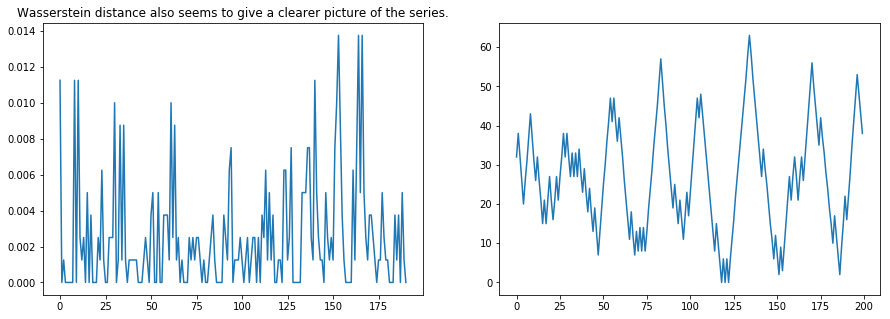

In [54]:
entropy_func_comparison([min([earth_mover_wasserstein_distance(X_w[i], q) for q in X_w[i + 1:i + w]]) for i in range(len(X_w) - w // 2)], X, 
                        title='Wasserstein distance also seems to give a clearer picture of the series.')